## Motivation
Cluster publishers a succesfull clustering could increase the accuracy of the click pred model. The clustering is primarily based on TF-IDF vectorization of bundle categories. For TF-IDF I have also utilized, NLTK's stemming for the extracting the root words for the categories.
* As we shall see in the cells below I've tried several approaches such as the novel Kmodes clustering for combining categorical and continous features.
* Simple Kmeans algorithm
* DBscan

In [1]:
import sys
print(sys.version)
sys.path.append("../")
import pandas as pd
import pymysql
import matplotlib.style as style
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import pymysql
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
%matplotlib inline
import seaborn as sns
import numpy as np
style.use('ggplot')
from tqdm import tqdm
from IPython.display import display, HTML
import matplotlib.cm as cm

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
con_commons = pymysql.connect(host="host_name", database='db_name', user="user_name",
                              password="password")

In [3]:
bundle_info = pd.read_sql(bundle_query, con_commons)
con_commons.close()

In [4]:
bundle_info["category"] = bundle_info.category.str.replace(";", " ")
bundle_info["content_rating"].fillna("None", inplace=True)
print(bundle_info.shape)
bundle_info.head()

(103978, 9)


,bundle_id,app_name,app_author,category,top_developer,price,rating,rating_count,content_rating
0,1000548274,1010 Block,SwiftStar,Games Entertainment Board Trivia,0,0.0,4.5,21.0,4+
1,1000773093,Rapala Fishing - Daily Catch,"Concrete Software, Inc.",Games Sports Sports Action,0,0.0,4.5,2316.0,4+
2,1000958628,Cannon Hero Must Die,Orangenose Studios,Games Action Arcade,0,0.0,5.0,734.0,4+
3,1000991178,Hindustan Times - News,HT Media,News,0,0.0,1.5,43.0,12+
4,1001013071,Loader 3D,"Tapinator, Inc.",Games Entertainment Simulation Action,0,0.0,5.0,9.0,4+


In [5]:
bundle_info["top_developer"] = bundle_info.top_developer.astype('category')
bundle_info["content_rating"] = bundle_info.content_rating.astype('category')

In [6]:
# for personalization vs personalisation
bundle_info["category"] = bundle_info["category"].str.replace(
    "lization", "lisation")

### TF-IDF to vectorize category and top developer and content rating
I am also using NLTK stemming to get all the root words

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 

In [8]:
tf = TfidfVectorizer(analyzer='word',  min_df=0, stop_words='english')
ps = PorterStemmer() 

In [9]:
def stemming_categories(x):
    words = word_tokenize(x)
    return " ".join([ps.stem(w) for w in words])

In [10]:
bundle_info['category_stemmed']=bundle_info["category"].apply(stemming_categories)

In [11]:
tfidf_matrix = tf.fit_transform(bundle_info['category_stemmed'])
type(tfidf_matrix)
tfidf_matrix.shape
#cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

(103978, 78)

In [12]:
" ".join(tf.get_feature_names())

'action adventur arcad art audio auto automot beauti board bodi book busi card casino casual catalog comic commun date demo design dice drink editor educ entertain event famili fashion financ fit food game garden health home hous librari lifestyl local magazin map medic men mind music navig network new newspap parent personalis photo photographi play player polit product puzzl race refer role scienc shop simul social sport strategi style tool travel trivia util vehicl video weather women word'

In [13]:
df = pd.DataFrame(tfidf_matrix.toarray())
df.head()

,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.610792,0.0,...,0.0,0.0,0.0,0.606122,0.0,0.0,0.0,0.0,0.0,0.0
1,0.396190,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.605810,0.0,0.629179,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.577033,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Dimensionality reduction

In [14]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [16]:
pca = PCA(n_components=df.shape[1])
pca.fit(tfidf_matrix.toarray())
X_pca = pca.transform(tfidf_matrix.toarray())

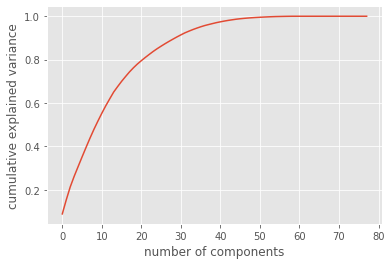

In [17]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [18]:
pca = PCA(n_components=30)
pca.fit(tfidf_matrix.toarray())
X_pca = pca.transform(tfidf_matrix.toarray())
X_pca.shape

(103978, 30)

In [19]:
df_PCA = pd.DataFrame(X_pca)

# df_PCA["price"] = bundle_info["price"]
# df_PCA["rating"] = bundle_info["rating"]
# df_PCA["rating_count"] = bundle_info["rating_count"]
# df_PCA["rating_count"] = df_PCA["rating_count"].fillna(0)
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(df_PCA.values)
df_PCA_scaled = pd.DataFrame(x_scaled)


#df_PCA_scaled["top_developer"] = bundle_info["top_developer"]
df_PCA_scaled["content_rating"] = bundle_info["content_rating"]
df_PCA_scaled.dtypes

0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
5                  float64
6                  float64
7                  float64
8                  float64
9                  float64
10                 float64
11                 float64
12                 float64
13                 float64
14                 float64
15                 float64
16                 float64
17                 float64
18                 float64
19                 float64
20                 float64
21                 float64
22                 float64
23                 float64
24                 float64
25                 float64
26                 float64
27                 float64
28                 float64
29                 float64
content_rating    category
dtype: object

### KModes clustering

In [20]:
from kmodes.kprototypes import KPrototypes

In [31]:
proto = KPrototypes(n_clusters=20, init='Huang', n_init=1, verbose=2, n_jobs=4)
clusters = proto.fit_predict(df_PCA_scaled, categorical=[30])

In [32]:
proto.gamma
#help(proto)

0.5000000000000044

In [33]:
bundle_info["cluster_kproto"] = pd.Series(clusters)
np.unique(clusters, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=uint16),
 array([ 8576, 14292, 13955,  7012,  6802,  1507,  9795,  8980,   107,
         3953,  1533,  4001,  1244,  1801,  7300,  1812,  4098,  4221,
          231,  2758]))

In [54]:
bundle_info[bundle_info["cluster_kproto"] == 1]["category_stemmed"].value_counts()

action                              3702
social                              1915
health & fit                        1282
travel & local                       836
financ                               808
                                    ... 
game health & fit puzzl strategi       1
food & drink magazin & newspap         1
game social network famili             1
game entertain dice casino             1
util game action                       1
Name: category_stemmed, Length: 244, dtype: int64

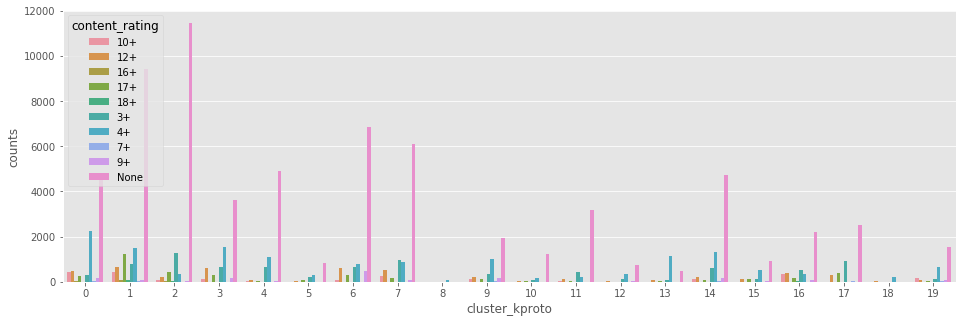

In [35]:
content_rating = bundle_info.groupby(
    ["cluster_kproto", "content_rating"]).size().reset_index(name='counts')
sns.set_context({"figure.figsize": (16, 5)})

sns.barplot("cluster_kproto","counts",hue="content_rating",data=content_rating)

### Kmeans Clustering

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans


In [37]:
def elbow_plot_kmeans(data, dataset_name, n_clusts):
    Sum_of_squared_distances = []

    for k in tqdm(n_clusts):
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(n_clusts, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title(f'Elbow Method For Optimal k {dataset_name}')
    plt.show()

100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


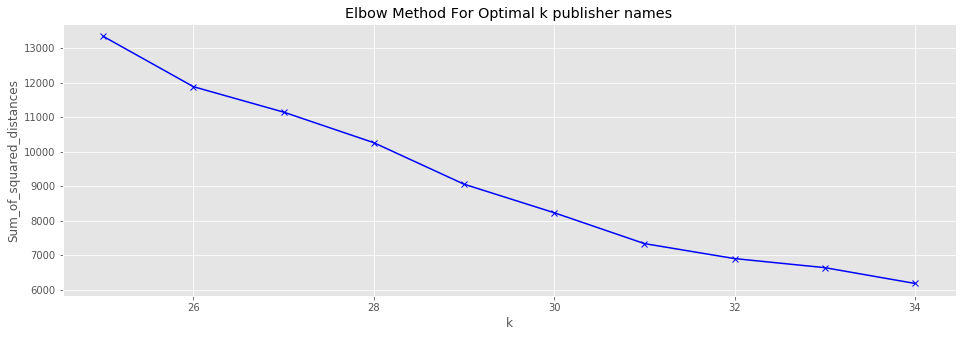

In [38]:
elbow_plot_kmeans(X_pca, "publisher names", range(25, 35))

In [39]:
km = KMeans(n_clusters=25)
km = km.fit(X_pca)
km.inertia_

13444.65351274197

In [40]:
bundle_info["cluster_kmeans"] = pd.Series(km.labels_)

In [41]:
for i in range(len(np.unique(km.labels_))):
    print(
        f"====================== cluster {i} {bundle_info.loc[bundle_info.cluster_kmeans==i].shape[0]} ==========================")
    print(bundle_info.loc[bundle_info.cluster_kmeans == i]
          ["category"].value_counts()[:5])

====================== cluster 0 4221 ==========================
Personalisation    4221
Name: category, dtype: int64
====================== cluster 1 6757 ==========================
Education              4333
Educational            1328
Reference Education     304
Education Books         111
Education Reference      91
Name: category, dtype: int64
====================== cluster 2 7852 ==========================
Entertainment                                         7810
Entertainment Games                                     30
Games Entertainment                                     11
Entertainment Magazines & Newspapers Entertainment       1
Name: category, dtype: int64
====================== cluster 3 3442 ==========================
Sports                            2429
Sports News                        261
News Sports                        150
Sports Entertainment               113
Games Sports Sports Simulation      24
Name: category, dtype: int64
====================== cluste

In [42]:
print(bundle_info.loc[bundle_info.cluster_kmeans == 3].shape)
print(bundle_info.loc[bundle_info.cluster_kmeans == 3]
          ["category"].value_counts()[:15])

(3442, 12)
Sports                            2429
Sports News                        261
News Sports                        150
Sports Entertainment               113
Games Sports Sports Simulation      24
Games Arcade Sports Sports          23
Games Sports Arcade Sports          19
Games Sports Sports Arcade          17
Sports Lifestyle                    15
Games Action Sports Sports          15
Games Simulation Sports Sports      14
Games Sports Simulation Sports      13
Games Action Sports                 12
Entertainment Sports                12
Sports Utilities                    11
Name: category, dtype: int64


### Train DBScan

In [43]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

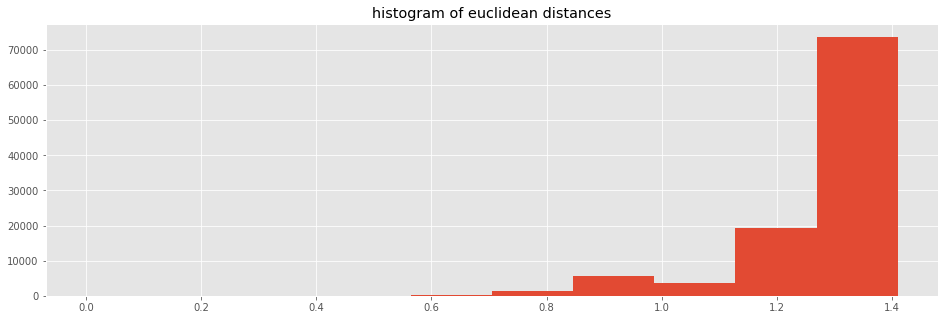

In [44]:
dist = euclidean_distances(X_pca[0:1,], X_pca)
len(dist[0])
plt.hist(dist[0])
plt.title("histogram of euclidean distances") 
plt.show()

In [45]:
clustering = DBSCAN(eps=0.2, min_samples=200, n_jobs=4).fit(X_pca)
np.unique(clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
        50, 51]),
 array([11530,   322,   299,   234,   440,   581,   407,  2429,   373,
         3902,   318,   209,   480,  1048,  4909,   216,  7810,   411,
         1389,  4222,  1282,   455,   232,   231,   356,   205,   534,
          322,   667,  2914,  1299,   569,   995,  5661,  2117,   800,
         3796,  2538,  1065,  3702,  4365,  1904,  5667,  3038,  1443,
          536,  1915,   708,   867,  1106,  3693,  3246,  4221]))

In [46]:
bundle_info["cluster_dbscan"] = pd.Series(clustering.labels_)

In [47]:
bundle_info.loc[bundle_info.cluster_dbscan == 100]["category"].value_counts()[:10]

Series([], Name: category, dtype: int64)

In [48]:
for i in range(-1,(len(np.unique(clustering.labels_))-1)):
    print(
        f"====================== cluster {i} {bundle_info.loc[bundle_info.cluster_dbscan==i].shape[0]} ==========================")
    print(bundle_info.loc[bundle_info.cluster_dbscan == i]
          ["category"].value_counts()[:5])

====================== cluster -1 11530 ==========================
Books Entertainment            132
Games Puzzle                   129
Health & Fitness Lifestyle     116
News Magazines & Newspapers    114
Sports Entertainment           113
Name: category, dtype: int64
====================== cluster 0 322 ==========================
Games Arcade Action    163
Games Action Arcade    159
Name: category, dtype: int64
====================== cluster 1 299 ==========================
News    299
Name: category, dtype: int64
====================== cluster 2 234 ==========================
Games Entertainment Simulation Action    49
Games Simulation Action Entertainment    40
Games Simulation Entertainment Action    40
Games Action Entertainment Simulation    37
Games Entertainment Action Simulation    33
Name: category, dtype: int64
====================== cluster 3 440 ==========================
Entertainment Lifestyle    281
Lifestyle Entertainment    159
Name: category, dtype: int64
=========

### TSNE over a subsample

In [49]:
max_label = max(km.labels_)
max_items = np.random.choice(range(X_pca.shape[0]), size=4000, replace=False)

In [51]:
labels = bundle_info.iloc[max_items, :]["cluster_kmeans"].values
max_label = max(labels)
label_subset = [cm.hsv(i/max_label) for i in labels]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.003s...
[t-SNE] Computed neighbors for 4000 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.048687
[t-SNE] KL divergence after 1000 iterations: -2.480101


Text(0.5, 1.0, 'TSNE Cluster Plot')

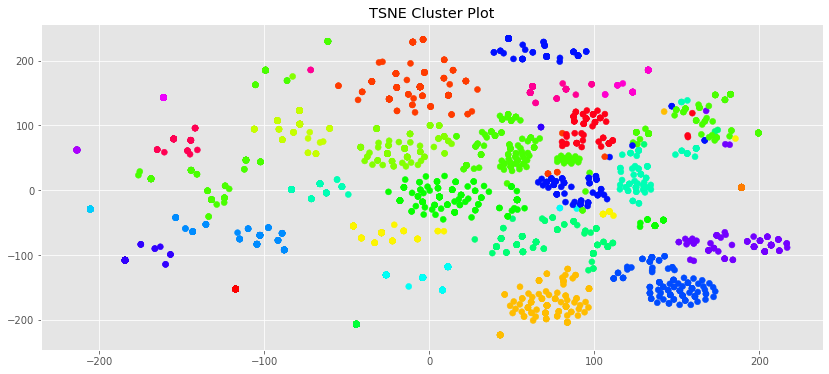

In [53]:
tsne_model = TSNE(perplexity=30, init='pca', verbose=1)
new_values = tsne_model.fit_transform(X_pca[max_items,:])

f, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.scatter(new_values[:,0], new_values[:,1], c=label_subset)
ax.set_title('TSNE Cluster Plot')

## Conclusion
* None of the above methods have yielded a reasonable number of clusters. 
* I was hoping for cluster sizes to the tune of less than 30.
* When the number of clusters is around 20 -30 we can see that some of the clusters are nonsensical. This is evident from the Kmeans elbow plots.